In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Epistemic Uncertainty
- uncertainty in the model due to lack of knowledge or data
- captured by Monte Carlo Dropout

In [19]:
# LEARN WHATS DROPOUT DOING
# whats monte carlo dropout

In [20]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data (reshape and normalize)
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [21]:
def create_model(dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),  # Dropout layer for uncertainty
        layers.Dense(10, activation='softmax')  # Output layer (10 classes for MNIST)
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = create_model()

In [22]:
# Train the model on the MNIST dataset
model.fit(x_train, y_train, epochs=1, batch_size=8, validation_split=0.9)

750/750 [==============================] - 10s 13ms/step - loss: 0.5831 - accuracy: 0.8136 - val_loss: 0.1569 - val_accuracy: 0.9518


In [23]:
# multiple forward passes
# calculate the variance between all the outputs

def monte_carlo_dropout(model, x_input, n_iter=100):
    # store predictions from multiple forward passes
    predictions = np.array([model(x_input, training=True) for _ in range(n_iter)])

    # mean of predictions
    mean_prediction = np.mean(predictions, axis=0)

    # variance of the predictions (uncertainty)
    variance_prediction = np.var(predictions, axis=0)

    return mean_prediction, variance_prediction

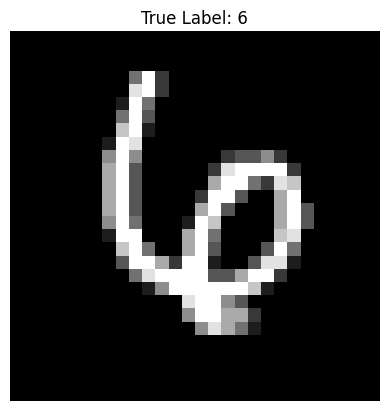

In [24]:
# sample
sample_index = slice(22,23)
x_sample = x_test[sample_index]

import matplotlib.pyplot as plt

# Select a sample image and its true label from the test set
#sample_index = 1  # You can change this to view different images
#x_sample = x_test[sample_index]
y_sample_true = np.argmax(y_test[sample_index])  # True label (in numeric form)

# Visualize the image
plt.imshow(x_sample.reshape(28, 28), cmap='gray')  # Reshape the image and display it
plt.title(f"True Label: {y_sample_true}")  # Add the true label as the title
plt.axis('off')  # Turn off axis for clarity
plt.show()

In [25]:
# get mean and uncertainty (variance) using Monte Carlo Dropout
mean_prediction, uncertainty = monte_carlo_dropout(model, x_sample, n_iter=100)

# results
print(f"Mean Prediction: {mean_prediction}\n")
print(f"Uncertainty (Variance): {uncertainty}")

Mean Prediction: [[1.6693130e-02 2.1799579e-02 3.7643232e-04 1.2598954e-04 1.5783396e-01
  7.1815867e-03 7.7382272e-01 1.0399577e-03 4.1378327e-03 1.6988808e-02]]

Uncertainty (Variance): [[7.4093346e-03 4.1299947e-03 2.6423677e-06 4.2603807e-07 5.5030726e-02
  2.8310486e-03 8.0457136e-02 1.8864986e-05 1.1692677e-03 5.6529115e-03]]


The reason we get multiple uncertainty values is because its the uncertainty values across all 7 classes

In [26]:
# GETTING SINGULAR UNCERTAINTY VALUE

# MEAN UNCERTAINTY (VARIANCE)
# overall average uncertainty across ALL classes
# stupid
# mean_uncertainty = np.mean(uncertainty)
# print(f"Mean Uncertainty: {mean_uncertainty}")

# VARIANCE OF PREDICTED CLASS
# we only care about uncertainty related to predicted class (class with highest mean probability)
print(f"Model Predictions (mean prediction): {mean_prediction}")
print(f"Model Uncertainty (variance): {uncertainty}")
predicted_class = np.argmax(mean_prediction)
print(f"Predicted Class: {predicted_class}")
class_uncertainty = uncertainty[0, predicted_class]
print(f"Uncertainty for predicted class {predicted_class}: {class_uncertainty}")

Model Predictions (mean prediction): [[1.6693130e-02 2.1799579e-02 3.7643232e-04 1.2598954e-04 1.5783396e-01
  7.1815867e-03 7.7382272e-01 1.0399577e-03 4.1378327e-03 1.6988808e-02]]
Model Uncertainty (variance): [[7.4093346e-03 4.1299947e-03 2.6423677e-06 4.2603807e-07 5.5030726e-02
  2.8310486e-03 8.0457136e-02 1.8864986e-05 1.1692677e-03 5.6529115e-03]]
Predicted Class: 6
Uncertainty for predicted class 6: 0.08045713603496552


In [27]:
print(uncertainty.shape)

(1, 10)


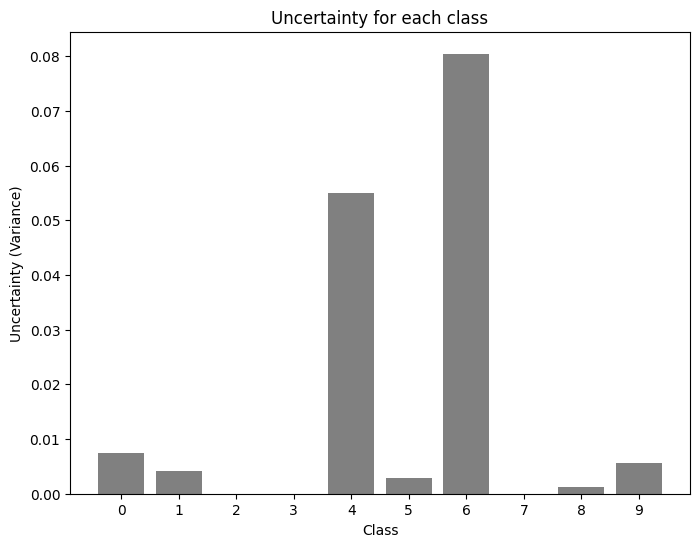

In [28]:
import matplotlib.pyplot as plt

def plot_uncertainty(uncertainty, mean_prediction):
    plt.figure(figsize=(8, 6))
    plt.bar(range(10), uncertainty[0], color='gray')
    plt.xticks(range(10), range(10))
    plt.title(f"Uncertainty for each class")
    plt.xlabel("Class")
    plt.ylabel("Uncertainty (Variance)")
    plt.show()

plot_uncertainty(uncertainty, mean_prediction)